## Non-stationary bandits

- Generate 2k 10-armed bandits. 

- Inital values $q_{*}(a) := E[R_t | A_t = a]$ are all equal to zero. 

- Each bandit gives reward that is generated as a sample from $N(q_*(a), 1)$. 

- After each step change value of $q_*(a)$ by adding a number generated from $N(0, 0.01)$.

- Use action-value method with $\alpha_n = 1/(n-1)$ resp. $\alpha_n = \alpha = 0.1$

- Use $\varepsilon = 0.1$

- Do 10k steps for each bandit 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
num_bandits = 200
num_runs = 1000
update_rule = "const"
## update_rule = "1/n"

In [3]:
class Bandit(object): 
    
    def __init__(self, k = 10, sd_R = 1.0, sd_q = 0.01, alpha = 0.1, update_rule = "const", mu = None): 
        """
        Bandit object. 

        Args: 
        k -- A `int`, number of levers
        sd_R -- A `float`, sd of reward 
        sd_q -- A `float`, sd of update for the mean values of reward
        alpha -- A `float`, weighting factor for constant updating of Q(a)
        update_rule -- A `string`, how to update Q(a) values
            "const" -- Q_{n+1} = Q_{n} + alpha *  (R_{n} - Q_{n})
            "1/n" -- Q_{n+1} = Q_{n} + (1/n * (R_{n} - Q_{n})
        mu -- A `np.array(float)`, initial values of q_{*}(a)

        Returns:
        -- 
        """
        if mu == None: 
            self.mu = np.zeros(k)
        self.k = k
        self.sd_R = sd_R
        self.sd_q = sd_q 
        self.alpha = alpha
        self.update_rule = update_rule
        
        self.Q_a = np.zeros(k)
        self.R_n = []
        self.n = np.ones(k)
    
    def do_action(self, a): 
        """
        Reward for action `a`. Updates values of q_{*}(a). 
        Updates values of Q_a and R_t. 
        
        Args: 
        a -- A `int`, action, number of lever pulled
        
        Returns:
        R -- A `float`, reward
        """
        R = self.mu[a] + np.random.randn()
        self.mu += np.random.randn(self.k) * self.sd_q
        self.R_n.append(R)
        factor = self.alpha
        if self.update_rule == "1/n":
            factor = 1/self.n[a]
            self.n += 1
        self.Q_a[a] = self.Q_a[a] + factor * (R - self.Q_a[a])
        
        return R 
    

    def select_action(self, epsilon = 0.1): 
        """
        Returns the next action based on the epsilon-greedy algorithm 

        Args: 
        epsilon -- A `float`, percentage of cases when non-greedy action
            is selected

        Returns: 
        action -- A `int`, number from 0 to self.k - 1, indicating the 
            number of lever to pull 
        """
        max_Q_value = np.max(self.Q_a)
        lever_is_greedy = self.Q_a == max_Q_value
        greedy_levers, = np.where(lever_is_greedy)
        non_greedy_levers, = np.where(~lever_is_greedy)
        if len(non_greedy_levers) == 0:  ## case when all levers have the same value 
            non_greedy_levers = greedy_levers

        r = np.random.uniform()

        if r <= epsilon: 
            action = np.random.choice(non_greedy_levers)
        else: 
            action = np.random.choice(greedy_levers)

        return action

### Plot some special cases

Algorithm of pulling levers is the following. In one step select lever with maximum $Q$ value in that step with probability $1 - \varepsilon$ and select lever with not maximum $Q$ with probability $\varepsilon$. At the beginning all levers have $Q$ equal to zero. 

After each step we receive reward for pulling some lever - lets say lever $a$ - and we update the $Q$ values. Update rule is the following: 

$$ Q_{n+1}(a) = Q_{n}(a) + \alpha_n * (R_{n}(a) - Q_{n}(a)) $$ 



- $Q_n(a)$ stands for estimate of "value" of lever $a$ after $n-1$ th pull of that lever (whatever "value" means)
- $R_n(a)$ stands for reward of lever $a$ in the $n$ th pull of that lever. 
- $\alpha_n$, generally $\alpha_n(a)$ stands for updating factor of value of lever $a$ in the $n$ th pull of that lever. 

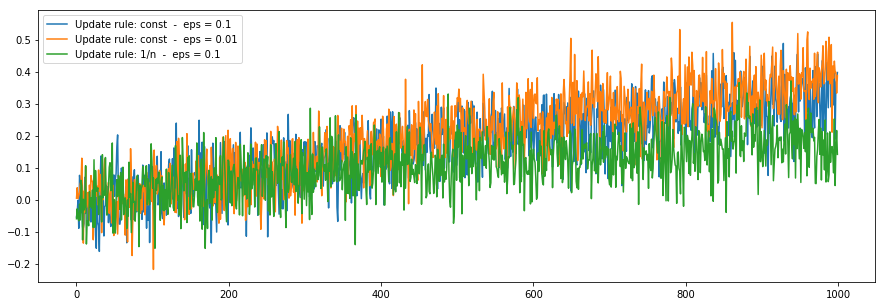

In [4]:
plt.figure(figsize = (15, 5))

for update_rule, epsilon in [("const", 0.1), ("const", 0.01), ("1/n", 0.1)]: 
    bandits = [Bandit(update_rule = update_rule) for i in range(num_bandits)]
    for i in range(num_runs):
        print(str(np.round(100 * i / num_runs, 1)) + " % completed")
        clear_output(True)
        for b in bandits: 
            a = b.select_action(epsilon=epsilon)
            b.do_action(a)

    rewards = np.array([b.R_n for b in bandits])
    mean_rewards = np.mean(rewards, axis = 0)
    label = "Update rule: "+update_rule+"  -  eps = " + str(epsilon)
    plt.plot(mean_rewards, label = label)
    plt.legend()

plt.show()